In [3]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
import seaborn as sns
from tqdm import tqdm
from sklearn.metrics import f1_score
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder
from sklearn import preprocessing
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler

from sklearn.preprocessing import MinMaxScaler    
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
import torch.nn as nn
import torch.nn.functional as F
import torch
import torch.optim as optim
from torch.utils.tensorboard import SummaryWriter
from torch.utils.data import Dataset
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
import sys
import torchvision
torch.backends.cudnn.enabled = False

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [22]:
train_dataset = pd.read_csv('/content/gdrive/MyDrive/Colab Notebooks/ITMO_AI_HACK/Train-dataset.csv')
train_dataset.head()

,WELL,X,Y,MD,GR,RT,CN,DEN,DEPOSITIONAL_ENVIRONMENT,LITH_NAME,LITH_CODE
0,Well-1,0.8179,2.9814,1602.0,83.939,3.166,0.250,2.344,Marine,Marly sandstone,1200
1,Well-1,0.8179,2.9814,1602.1,84.166,3.135,0.246,2.352,Marine,Marly sandstone,1200
2,Well-1,0.8179,2.9814,1602.2,85.055,3.089,0.244,2.352,Marine,Marly sandstone,1200
3,Well-1,0.8179,2.9814,1602.3,86.352,3.042,0.242,2.355,Marine,Sandy marl,1300
4,Well-1,0.8179,2.9814,1602.4,87.614,3.003,0.241,2.369,Marine,Sandy marl,1300


In [23]:
train_dataset = train_dataset.drop(['WELL', 'LITH_NAME'], axis=1)
train_dataset.head()

,X,Y,MD,GR,RT,CN,DEN,DEPOSITIONAL_ENVIRONMENT,LITH_CODE
0,0.8179,2.9814,1602.0,83.939,3.166,0.250,2.344,Marine,1200
1,0.8179,2.9814,1602.1,84.166,3.135,0.246,2.352,Marine,1200
2,0.8179,2.9814,1602.2,85.055,3.089,0.244,2.352,Marine,1200
3,0.8179,2.9814,1602.3,86.352,3.042,0.242,2.355,Marine,1300
4,0.8179,2.9814,1602.4,87.614,3.003,0.241,2.369,Marine,1300


In [24]:
ohe = OneHotEncoder(sparse=False)
new_ohe_features = ohe.fit_transform(train_dataset.DEPOSITIONAL_ENVIRONMENT.values.reshape(-1,1))
tmp = pd.DataFrame(new_ohe_features, columns=['ENV' + 
                                             str(i) for i in range(new_ohe_features.shape[1])])
train_dataset = pd.concat([train_dataset, tmp], axis=1)
train_dataset = train_dataset.drop(['DEPOSITIONAL_ENVIRONMENT'], axis=1)
cols = train_dataset.columns.tolist()
cols = cols[0:7] + cols[8:11] + cols[7:8]
train_dataset = train_dataset[cols]
train_dataset

,X,Y,MD,GR,RT,CN,DEN,ENV0,ENV1,ENV2,LITH_CODE
0,0.8179,2.9814,1602.0,83.9390,3.1660,0.25000,2.3440,0.0,1.0,0.0,1200
1,0.8179,2.9814,1602.1,84.1660,3.1350,0.24600,2.3520,0.0,1.0,0.0,1200
2,0.8179,2.9814,1602.2,85.0550,3.0890,0.24400,2.3520,0.0,1.0,0.0,1200
3,0.8179,2.9814,1602.3,86.3520,3.0420,0.24200,2.3550,0.0,1.0,0.0,1300
4,0.8179,2.9814,1602.4,87.6140,3.0030,0.24100,2.3690,0.0,1.0,0.0,1300
...,...,...,...,...,...,...,...,...,...,...,...
45744,3.0000,0.0000,2275.2,103.6016,1.0789,0.29558,2.3783,0.0,1.0,0.0,400
45745,3.0000,0.0000,2275.3,102.8472,1.0683,0.29264,2.3651,0.0,1.0,0.0,400
45746,3.0000,0.0000,2275.4,102.5699,1.0790,0.29425,2.3531,0.0,1.0,0.0,400
45747,3.0000,0.0000,2275.5,102.7901,1.1045,0.30096,2.3430,0.0,1.0,0.0,400


In [25]:
def corr_df(x, corr_val):
    '''
    Obj: Drops features that are strongly correlated to other features.
          This lowers model complexity, and aids in generalizing the model.
    Inputs:
          df: features df (x)
          corr_val: Columns are dropped relative to the corr_val input (e.g. 0.8)
    Output: df that only includes uncorrelated features
    '''

    # Creates Correlation Matrix and Instantiates
    corr_matrix = x.corr()
    iters = range(len(corr_matrix.columns) - 1)
    drop_cols = []

    # Iterates through Correlation Matrix Table to find correlated columns
    for i in iters:
        for j in range(i):
            item = corr_matrix.iloc[j:(j+1), (i+1):(i+2)]
            col = item.columns
            row = item.index
            val = item.values
            if val >= corr_val:
                # Prints the correlated feature set and the corr val
                print(col.values[0], "|", row.values[0], "|", round(val[0][0], 2))
                drop_cols.append(i)

    drops = sorted(set(drop_cols))[::-1]

    # Drops the correlated columns
    for i in drops:
        col = x.iloc[:, (i+1):(i+2)].columns.values
        df = x.drop(col, axis=1)

    return df

corr_train_dataset = corr_df(train_dataset, 0.6)
corr_train_dataset

DEN | MD | 0.64
ENV1 | MD | 0.74


,X,Y,MD,GR,RT,CN,ENV0,ENV1,ENV2,LITH_CODE
0,0.8179,2.9814,1602.0,83.9390,3.1660,0.25000,0.0,1.0,0.0,1200
1,0.8179,2.9814,1602.1,84.1660,3.1350,0.24600,0.0,1.0,0.0,1200
2,0.8179,2.9814,1602.2,85.0550,3.0890,0.24400,0.0,1.0,0.0,1200
3,0.8179,2.9814,1602.3,86.3520,3.0420,0.24200,0.0,1.0,0.0,1300
4,0.8179,2.9814,1602.4,87.6140,3.0030,0.24100,0.0,1.0,0.0,1300
...,...,...,...,...,...,...,...,...,...,...
45744,3.0000,0.0000,2275.2,103.6016,1.0789,0.29558,0.0,1.0,0.0,400
45745,3.0000,0.0000,2275.3,102.8472,1.0683,0.29264,0.0,1.0,0.0,400
45746,3.0000,0.0000,2275.4,102.5699,1.0790,0.29425,0.0,1.0,0.0,400
45747,3.0000,0.0000,2275.5,102.7901,1.1045,0.30096,0.0,1.0,0.0,400


In [122]:
X_corr = corr_train_dataset.iloc[:,0:-1]
y_corr = corr_train_dataset.iloc[:,-1]

X_corr_train, X_corr_test, y_corr_train, y_corr_test = train_test_split(X_corr, y_corr,
                                                                       train_size=0.8,
                                                                       random_state=6,
                                                                       stratify=y_corr)

In [123]:
X_corr_train

,X,Y,MD,GR,RT,CN,ENV0,ENV1,ENV2
5973,-1.037631,1.425599,-0.637307,-0.488138,-0.021436,0.604412,1.259249,-0.480655,-0.860760
32373,1.313758,-1.303850,-0.911628,-0.191855,0.002168,-0.039322,1.259249,-0.480655,-0.860760
29727,1.313758,-1.303850,-1.597042,-0.255410,-0.008915,0.997926,1.259249,-0.480655,-0.860760
39829,1.313758,-1.303850,1.019757,-0.277408,-0.022516,-0.601116,-0.794124,-0.480655,1.161764
32109,1.313758,-1.303850,-0.980014,-0.924279,0.002894,0.203238,1.259249,-0.480655,-0.860760
...,...,...,...,...,...,...,...,...,...
38488,1.313758,-1.303850,0.672387,-1.023006,-0.026831,-0.308006,-0.794124,-0.480655,1.161764
28113,-0.350631,0.598758,0.629602,0.266331,-0.032704,-0.800572,-0.794124,-0.480655,1.161764
22660,-0.350631,0.598758,-0.782930,1.099078,-0.023502,1.489316,1.259249,-0.480655,-0.860760
5927,-1.037631,1.425599,-0.649223,-0.369649,-0.039001,0.354817,1.259249,-0.480655,-0.860760


In [124]:
scaler_corr = preprocessing.StandardScaler().fit(X_corr_train)
corr_train_dataset.iloc[:,0:-1] = scaler_corr.transform(corr_train_dataset.iloc[:,0:-1])
corr_train_dataset

,X,Y,MD,GR,RT,CN,ENV0,ENV1,ENV2,LITH_CODE
0,-0.837047,1.410029,0.804176,-0.060047,-0.030136,-1.246056,-0.792417,2.072991,-0.860613,1200
1,-0.837047,1.410029,0.804435,-0.045766,-0.030613,-1.298183,-0.792417,2.072991,-0.860613,1200
2,-0.837047,1.410029,0.804693,0.010162,-0.031322,-1.324246,-0.792417,2.072991,-0.860613,1200
3,-0.837047,1.410029,0.804951,0.091757,-0.032046,-1.350309,-0.792417,2.072991,-0.860613,1300
4,-0.837047,1.410029,0.805210,0.171151,-0.032646,-1.363340,-0.792417,2.072991,-0.860613,1300
...,...,...,...,...,...,...,...,...,...,...
45744,1.310827,-1.300856,2.543031,1.176949,-0.062284,-0.652078,-0.792417,2.072991,-0.860613,400
45745,1.310827,-1.300856,2.543289,1.129488,-0.062447,-0.690391,-0.792417,2.072991,-0.860613,400
45746,1.310827,-1.300856,2.543547,1.112043,-0.062283,-0.669410,-0.792417,2.072991,-0.860613,400
45747,1.310827,-1.300856,2.543806,1.125896,-0.061890,-0.581969,-0.792417,2.072991,-0.860613,400


In [126]:
X_corr = corr_train_dataset.iloc[:,0:-1]
y_corr = corr_train_dataset.iloc[:,-1]

X_corr_train, X_corr_test, y_corr_train, y_corr_test = train_test_split(X_corr, y_corr,
                                                                       train_size=0.8,
                                                                       random_state=6,
                                                                       stratify=y_corr)

In [115]:
train_corr = pd.concat([X_corr_train, y_corr_train], axis=1)
train_corr

,X,Y,MD,GR,RT,CN,ENV0,ENV1,ENV2,LITH_CODE
33125,1.313758,-1.303850,-0.716832,1.361323,-0.028439,0.343393,1.259249,-0.480655,-0.860760,1000
5442,-1.037631,1.425599,-0.775115,-1.091417,0.000197,0.446703,1.259249,-0.480655,-0.860760,600
25955,-0.350631,0.598758,0.070599,-0.365367,-0.018691,-0.188620,-0.794124,-0.480655,1.161764,600
40490,1.313758,-1.303850,1.190981,0.856627,-0.049853,0.061385,-0.794124,2.080493,-0.860760,400
7,-0.836419,1.408677,0.809936,0.409774,-0.033316,-1.365500,-0.794124,2.080493,-0.860760,1300
...,...,...,...,...,...,...,...,...,...,...
21137,-0.350631,0.598758,-1.177445,1.429192,-0.018660,1.070159,1.259249,-0.480655,-0.860760,100
34800,1.313758,-1.303850,-0.282944,0.839163,-0.026919,-0.167329,1.259249,-0.480655,-0.860760,100
40579,1.313758,-1.303850,1.214035,0.058374,-0.026610,-1.025760,-0.794124,2.080493,-0.860760,1300
9884,-0.897019,0.500589,-1.063942,0.980998,-0.029746,0.484592,1.259249,-0.480655,-0.860760,100


In [116]:
test_corr = pd.concat([X_corr_test, y_corr_test], axis=1)
test_corr

,X,Y,MD,GR,RT,CN,ENV0,ENV1,ENV2,LITH_CODE
1860,-0.573522,1.182951,-0.093587,-1.647590,0.056332,-0.072369,-0.794124,-0.480655,1.161764,600
27958,-0.350631,0.598758,0.589451,0.334029,-0.032909,-0.579564,-0.794124,-0.480655,1.161764,400
43631,1.313758,-1.303850,2.004618,1.219318,-0.055892,-0.006145,-0.794124,2.080493,-0.860760,400
16403,-0.897019,0.500589,0.624725,0.663605,-0.029075,-0.947257,-0.794124,-0.480655,1.161764,400
1519,-0.459120,1.109347,0.857625,-0.109841,-0.022579,-0.869147,-0.794124,2.080493,-0.860760,1300
...,...,...,...,...,...,...,...,...,...,...
42441,1.313758,-1.303850,1.696364,1.397288,-0.027974,-1.074742,-0.794124,2.080493,-0.860760,400
44753,1.313758,-1.303850,2.295259,-0.559106,-0.029030,-1.274981,-0.794124,2.080493,-0.860760,600
14941,-0.897019,0.500589,0.246011,-0.098506,-0.010264,-0.566110,-0.794124,-0.480655,1.161764,500
16466,-0.897019,0.500589,0.641044,0.061850,-0.029135,-0.811152,-0.794124,-0.480655,1.161764,400


In [83]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score
rfc = RandomForestClassifier()
rfc.fit(X_corr_train, y_corr_train)
display(rfc.score(X_corr_train, y_corr_train))

1.0

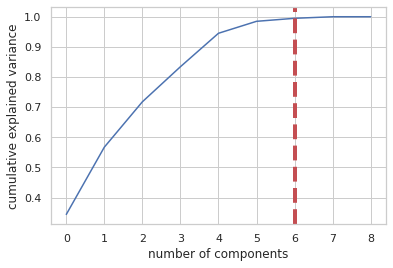

None

,Cumulative Variance Ratio,Explained Variance Ratio
0,0.344001,3.440011e-01
1,0.567266,2.232650e-01
2,0.717773,1.505066e-01
3,0.834152,1.163792e-01
4,0.945143,1.109913e-01
5,0.984818,3.967433e-02
6,0.994824,1.000608e-02
7,1.000000,5.176393e-03
8,1.000000,3.094979e-32


In [43]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
pca_test = PCA(n_components=9)
pca_test.fit(X_corr_train)
sns.set(style='whitegrid')
plt.plot(np.cumsum(pca_test.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')
plt.axvline(linewidth=4, color='r', linestyle = '--', x=6, ymin=0, ymax=1)
display(plt.show())
evr = pca_test.explained_variance_ratio_
cvr = np.cumsum(pca_test.explained_variance_ratio_)
pca_df = pd.DataFrame()
pca_df['Cumulative Variance Ratio'] = cvr
pca_df['Explained Variance Ratio'] = evr
display(pca_df.head(10))

In [117]:
pca = PCA(n_components=6)
pca.fit(X_corr_train)
X_train_scaled_pca = pca.transform(X_corr_train)
X_test_scaled_pca = pca.transform(X_corr_test)

In [118]:
rfc2 = RandomForestClassifier()
rfc2.fit(X_train_scaled_pca, y_corr_train)
display(rfc2.score(X_train_scaled_pca, y_corr_train))

0.9999375468398701

In [119]:
f1_score(y_corr_test,rfc2.predict(X_test_scaled_pca), average='macro' )

0.5866672337982606

In [50]:
from sklearn.model_selection import RandomizedSearchCV
n_estimators = [int(x) for x in np.linspace(start = 100, stop = 1000, num = 10)]
max_features = ['log2', 'sqrt']
max_depth = [int(x) for x in np.linspace(start = 1, stop = 15, num = 15)]
min_samples_split = [int(x) for x in np.linspace(start = 2, stop = 50, num = 10)]
min_samples_leaf = [int(x) for x in np.linspace(start = 2, stop = 50, num = 10)]
bootstrap = [True, False]
param_dist = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
rs = RandomizedSearchCV(rfc2, 
                        param_dist, 
                        n_iter = 100, 
                        cv = 3, 
                        verbose = 1, 
                        n_jobs=-1, 
                        random_state=0)
rs.fit(X_train_scaled_pca, y_corr_train)
rs.best_params_

Fitting 3 folds for each of 100 candidates, totalling 300 fits


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  % (min_groups, self.n_splits)), UserWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
/usr/local/lib/python3.7/dist-packages/joblib/externals/loky/process_executor.py:691: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed: 15.4min
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed: 66.8min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed: 97.0min finished


{'bootstrap': False,
 'max_depth': 15,
 'max_features': 'sqrt',
 'min_samples_leaf': 2,
 'min_samples_split': 23,
 'n_estimators': 600}

In [52]:
rs_df = pd.DataFrame(rs.cv_results_).sort_values('rank_test_score').reset_index(drop=True)
rs_df = rs_df.drop([
            'mean_fit_time', 
            'std_fit_time', 
            'mean_score_time',
            'std_score_time', 
            'params', 
            'split0_test_score', 
            'split1_test_score', 
            'split2_test_score', 
            'std_test_score'],
            axis=1)
rs_df.head(10)

,param_n_estimators,param_min_samples_split,param_min_samples_leaf,param_max_features,param_max_depth,param_bootstrap,mean_test_score,rank_test_score
0,600,23,2,sqrt,15,False,0.763955,1
1,700,12,2,sqrt,13,False,0.763300,2
2,400,23,2,sqrt,14,False,0.761551,3
3,700,23,7,log2,15,False,0.759775,4
4,700,2,2,log2,11,True,0.750594,5
5,100,2,18,sqrt,15,False,0.746441,6
6,300,28,7,log2,13,True,0.745731,7
7,500,12,18,sqrt,13,False,0.744501,8
8,800,28,12,sqrt,14,True,0.743709,9
9,300,2,23,log2,14,False,0.741250,10


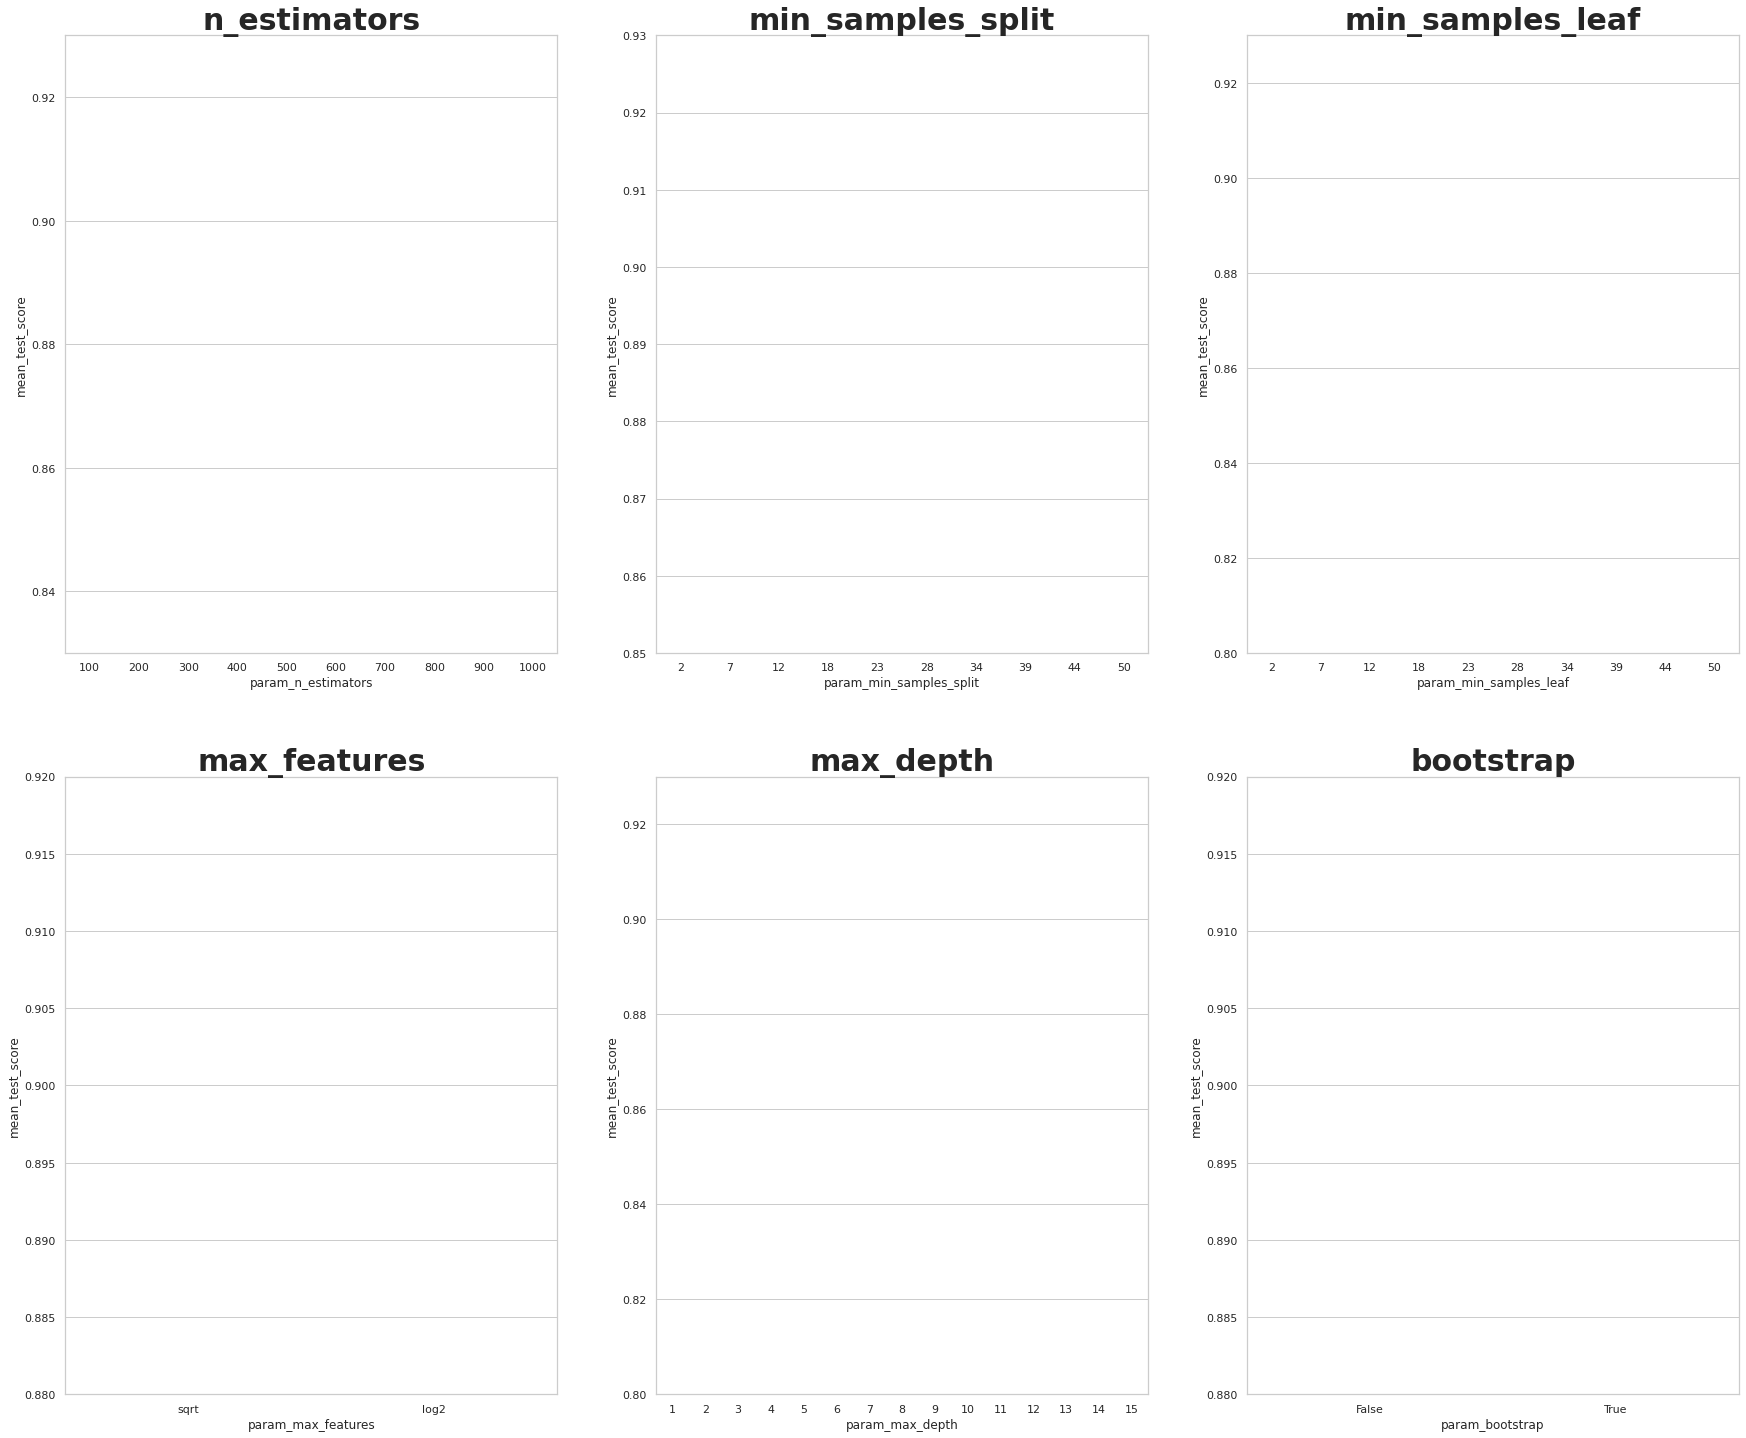

In [54]:
fig, axs = plt.subplots(ncols=3, nrows=2)
sns.set(style="whitegrid", color_codes=True, font_scale = 2)
fig.set_size_inches(30,25)
sns.barplot(x='param_n_estimators', y='mean_test_score', data=rs_df, ax=axs[0,0], color='lightgrey')
axs[0,0].set_ylim([.83,.93])
axs[0,0].set_title(label = 'n_estimators', size=30, weight='bold')
sns.barplot(x='param_min_samples_split', y='mean_test_score', data=rs_df, ax=axs[0,1], color='coral')
axs[0,1].set_ylim([.85,.93])
axs[0,1].set_title(label = 'min_samples_split', size=30, weight='bold')
sns.barplot(x='param_min_samples_leaf', y='mean_test_score', data=rs_df, ax=axs[0,2], color='lightgreen')
axs[0,2].set_ylim([.80,.93])
axs[0,2].set_title(label = 'min_samples_leaf', size=30, weight='bold')
sns.barplot(x='param_max_features', y='mean_test_score', data=rs_df, ax=axs[1,0], color='wheat')
axs[1,0].set_ylim([.88,.92])
axs[1,0].set_title(label = 'max_features', size=30, weight='bold')
sns.barplot(x='param_max_depth', y='mean_test_score', data=rs_df, ax=axs[1,1], color='lightpink')
axs[1,1].set_ylim([.80,.93])
axs[1,1].set_title(label = 'max_depth', size=30, weight='bold')
sns.barplot(x='param_bootstrap',y='mean_test_score', data=rs_df, ax=axs[1,2], color='skyblue')
axs[1,2].set_ylim([.88,.92])
axs[1,2].set_title(label = 'bootstrap', size=30, weight='bold')
plt.show()

In [55]:
from sklearn.model_selection import GridSearchCV
n_estimators = [400,500,600,700]
max_features = ['sqrt']
max_depth = [13,14,15]
min_samples_split = [12,23]
min_samples_leaf = [2]
bootstrap = [False]
param_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
gs = GridSearchCV(rfc2, param_grid, cv = 3, verbose = 1, n_jobs=-1)
gs.fit(X_train_scaled_pca, y_corr_train)
rfc_3 = gs.best_estimator_
gs.best_params_

Fitting 3 folds for each of 24 candidates, totalling 72 fits


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  % (min_groups, self.n_splits)), UserWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed: 29.7min
[Parallel(n_jobs=-1)]: Done  72 out of  72 | elapsed: 47.1min finished


{'bootstrap': False,
 'max_depth': 15,
 'max_features': 'sqrt',
 'min_samples_leaf': 2,
 'min_samples_split': 12,
 'n_estimators': 600}

In [56]:
rfc2=RandomForestClassifier( max_features='sqrt', n_estimators= 600,
                            max_depth=15,min_samples_leaf=2,min_samples_split=12, n_jobs=-1)

In [57]:
rfc2.fit(X_corr_train, y_corr_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=15, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=2, min_samples_split=12,
                       min_weight_fraction_leaf=0.0, n_estimators=600,
                       n_jobs=-1, oob_score=False, random_state=None, verbose=0,
                       warm_start=False)

In [58]:
f1_score(y_corr_test,rfc2.predict(X_corr_test), average='macro' )

0.7107860373897634

In [127]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score
rfc3 = RandomForestClassifier()
rfc3.fit(X_corr_train, y_corr_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [128]:
f1_score(y_corr_test,rfc3.predict(X_corr_test), average='macro' )

0.8457483917996936

In [62]:
train_dataset = pd.read_csv('/content/gdrive/MyDrive/Colab Notebooks/ITMO_AI_HACK/Train-dataset.csv')
train_dataset.head()

,WELL,X,Y,MD,GR,RT,CN,DEN,DEPOSITIONAL_ENVIRONMENT,LITH_NAME,LITH_CODE
0,Well-1,0.8179,2.9814,1602.0,83.939,3.166,0.250,2.344,Marine,Marly sandstone,1200
1,Well-1,0.8179,2.9814,1602.1,84.166,3.135,0.246,2.352,Marine,Marly sandstone,1200
2,Well-1,0.8179,2.9814,1602.2,85.055,3.089,0.244,2.352,Marine,Marly sandstone,1200
3,Well-1,0.8179,2.9814,1602.3,86.352,3.042,0.242,2.355,Marine,Sandy marl,1300
4,Well-1,0.8179,2.9814,1602.4,87.614,3.003,0.241,2.369,Marine,Sandy marl,1300


In [63]:
train_dataset = train_dataset.drop(['WELL', 'LITH_NAME'], axis=1)
train_dataset.head()

,X,Y,MD,GR,RT,CN,DEN,DEPOSITIONAL_ENVIRONMENT,LITH_CODE
0,0.8179,2.9814,1602.0,83.939,3.166,0.250,2.344,Marine,1200
1,0.8179,2.9814,1602.1,84.166,3.135,0.246,2.352,Marine,1200
2,0.8179,2.9814,1602.2,85.055,3.089,0.244,2.352,Marine,1200
3,0.8179,2.9814,1602.3,86.352,3.042,0.242,2.355,Marine,1300
4,0.8179,2.9814,1602.4,87.614,3.003,0.241,2.369,Marine,1300


In [64]:
ohe = OneHotEncoder(sparse=False)
new_ohe_features = ohe.fit_transform(train_dataset.DEPOSITIONAL_ENVIRONMENT.values.reshape(-1,1))
tmp = pd.DataFrame(new_ohe_features, columns=['ENV' + 
                                             str(i) for i in range(new_ohe_features.shape[1])])
train_dataset = pd.concat([train_dataset, tmp], axis=1)
train_dataset = train_dataset.drop(['DEPOSITIONAL_ENVIRONMENT'], axis=1)
cols = train_dataset.columns.tolist()
cols = cols[0:7] + cols[8:11] + cols[7:8]
train_dataset = train_dataset[cols]
train_dataset

,X,Y,MD,GR,RT,CN,DEN,ENV0,ENV1,ENV2,LITH_CODE
0,0.8179,2.9814,1602.0,83.9390,3.1660,0.25000,2.3440,0.0,1.0,0.0,1200
1,0.8179,2.9814,1602.1,84.1660,3.1350,0.24600,2.3520,0.0,1.0,0.0,1200
2,0.8179,2.9814,1602.2,85.0550,3.0890,0.24400,2.3520,0.0,1.0,0.0,1200
3,0.8179,2.9814,1602.3,86.3520,3.0420,0.24200,2.3550,0.0,1.0,0.0,1300
4,0.8179,2.9814,1602.4,87.6140,3.0030,0.24100,2.3690,0.0,1.0,0.0,1300
...,...,...,...,...,...,...,...,...,...,...,...
45744,3.0000,0.0000,2275.2,103.6016,1.0789,0.29558,2.3783,0.0,1.0,0.0,400
45745,3.0000,0.0000,2275.3,102.8472,1.0683,0.29264,2.3651,0.0,1.0,0.0,400
45746,3.0000,0.0000,2275.4,102.5699,1.0790,0.29425,2.3531,0.0,1.0,0.0,400
45747,3.0000,0.0000,2275.5,102.7901,1.1045,0.30096,2.3430,0.0,1.0,0.0,400


In [65]:
X = train_dataset.iloc[:,0:-1]
y = train_dataset.iloc[:,-1]
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    train_size=0.8,
                                                    random_state=6,
                                                    stratify=y)

In [66]:
scaler = preprocessing.StandardScaler().fit(X_train)
train_dataset.iloc[:,0:-1] = scaler.transform(train_dataset.iloc[:,0:-1])
train_dataset

,X,Y,MD,GR,RT,CN,DEN,ENV0,ENV1,ENV2,LITH_CODE
0,-0.837047,1.410029,0.804176,-0.060047,-0.030136,-1.246056,0.931460,-0.792417,2.072991,-0.860613,1200
1,-0.837047,1.410029,0.804435,-0.045766,-0.030613,-1.298183,0.983796,-0.792417,2.072991,-0.860613,1200
2,-0.837047,1.410029,0.804693,0.010162,-0.031322,-1.324246,0.983796,-0.792417,2.072991,-0.860613,1200
3,-0.837047,1.410029,0.804951,0.091757,-0.032046,-1.350309,1.003422,-0.792417,2.072991,-0.860613,1300
4,-0.837047,1.410029,0.805210,0.171151,-0.032646,-1.363340,1.095009,-0.792417,2.072991,-0.860613,1300
...,...,...,...,...,...,...,...,...,...,...,...
45744,1.310827,-1.300856,2.543031,1.176949,-0.062284,-0.652078,1.155849,-0.792417,2.072991,-0.860613,400
45745,1.310827,-1.300856,2.543289,1.129488,-0.062447,-0.690391,1.069495,-0.792417,2.072991,-0.860613,400
45746,1.310827,-1.300856,2.543547,1.112043,-0.062283,-0.669410,0.990992,-0.792417,2.072991,-0.860613,400
45747,1.310827,-1.300856,2.543806,1.125896,-0.061890,-0.581969,0.924918,-0.792417,2.072991,-0.860613,400


In [67]:
X = train_dataset.iloc[:,0:-1]
y = train_dataset.iloc[:,-1]
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    train_size=0.8,
                                                    random_state=6,
                                                    stratify=y)

In [68]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score
rfc3 = RandomForestClassifier()
rfc3.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [69]:
f1_score(y_test,rfc3.predict(X_test), average='macro' )

0.7932165878179689